# **CVPS20 // Assignment 6**

assigned : **Nov 25, 2020**

DUE : **Dec 2, 2020 11:59pm**

## Mapping Fluid Flow with Particle Image Velocimetry

<img src="https://i.ytimg.com/vi/uhBDn3brODk/hqdefault.jpg" width=250x>

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


One of the most powerful techniques for determining flow characteristics in fluid dynamics experiments is to infuse the fluid with "tracer particles".  In their simplest form, these are microspheres that are illuminated with external lighting sources.  With appropriate tracking techniques, complex configurations can be used to explore everything from obstacles and vortex shedding as a function of fluid viscosity, to the transition to chaotic fluid element trajectories in cyclically forced systems.  In this assignment, you will use a simple example of a laminar fluid flow (extracted from [this video](https://www.youtube.com/watch?v=r6mWbvULkOU)) embedded with tracer particles to implement a tracker and perform "[particle image velocimetry](https://en.wikipedia.org/wiki/Particle_image_velocimetry)" to determine flow characteristics.

***IMPORTANT -  prior to working on this notebook, be sure to watch the `cvps20_111920_tracking.mp4` video in the `111920` folder in `cvps20/week12/`.***

<b>

Rules for homeworks:

1. You may work with other students in the class, but if you do, each student with whom you worked <u>must</u> be listed in this notebook in the first cell below.  Direct copying from someone else's notebook is not permitted.

2. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

3. Late homeworks will assess a 15% late penalty up to 3 days after the due date and a 50% late penalty until the end of the term (see CVPS20 syllabus).

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**Please list the names of the other students with whom you worked for this assignment (if none, put "None").**

none

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage.measurements as snm 
from matplotlib import animation

In [ ]:
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["animation.html"] = "jshtml"

In [ ]:
!pip install filterpy
!pip install lap

     |████████████████████████████████| 184kB 4.2MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110453 sha256=51adaf526086c1aac01ae9c5e7a2e69be9c5cbf333676bf8349d677225293877
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy
     |████████████████████████████████| 1.5MB 5.1MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589010 sha256=8db89c61ec272d4e87b9f6839343c4503a4edab543c004f8b957ad130b2d61b5
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap


In [ ]:
!git clone https://github.com/gdobler/sort.git

Cloning into 'sort'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (201/201), 1.20 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
cp sort/sort.py .

In [ ]:
from sort import *

**Create an `opencv` video capture linked to the video `piv_tamu.mov` in the `data/piv/` folder inside of `cvps20/`.**

In [ ]:
# -- load the video
fname =  '/content/drive/MyDrive/cvps20/data/piv/piv_tamu.mov'
cap = cv2.VideoCapture(fname)

In [ ]:
# -- get capture params
nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
nrow = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ncol = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

print("video is : ({0}, {1}, {2})".format(nfr, nrow, ncol))

video is : (2412, 1068, 1448)


**Read in 100 frames <u>starting at the 1200th frame</u> and only reading every <u>6th</u> frame thereafter$^{\dagger}$, keeping only the <u>red</u> channel and converting the image to $0$ to $1$.**

<small>$^{\dagger}$ i.e., read in frames 1200, 1206, 1212, 1218, etc. until you have read in 100 frames in total. </small>

In [ ]:
# -- create images container
imgs = []

# -- read in every fifth frame (and every other pixel) of the video capture
for ii in range(1800):

  if ii >= 1200:
    if (ii%6) == 0:
      imgs.append(cap.read()[1][:, :, -1]/255)
    else:
      cap.read()
  else:
    cap.read()

In [ ]:
np.asarray(imgs).shape

(100, 1068, 1448)

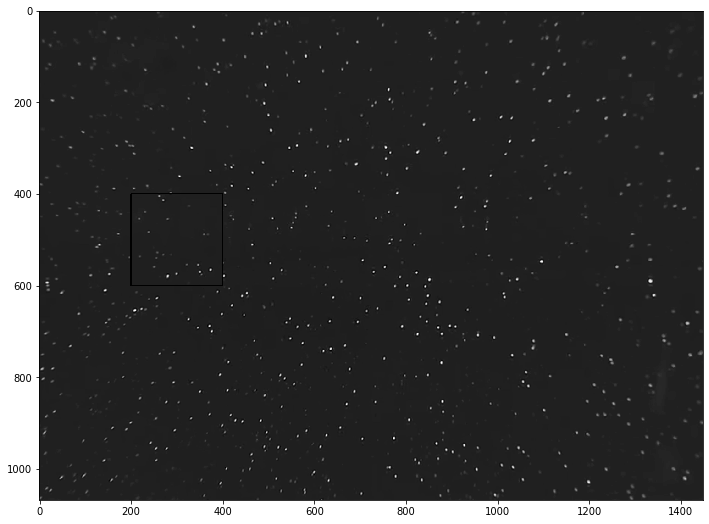

In [ ]:
plt.imshow(imgs[0])

In [ ]:
cv2.rectangle(imgs[0], (200,400), (400,600), (0,255,0), 2 )


array([[0.13333333, 0.13333333, 0.12941176, ..., 0.12941176, 0.12941176,
        0.12941176],
       [0.13333333, 0.13333333, 0.12941176, ..., 0.12941176, 0.12941176,
        0.12941176],
       [0.12941176, 0.12941176, 0.13333333, ..., 0.12941176, 0.12941176,
        0.12941176],
       ...,
       [0.36470588, 0.39607843, 0.36862745, ..., 0.14117647, 0.14117647,
        0.14117647],
       [0.31372549, 0.29411765, 0.25882353, ..., 0.13333333, 0.13333333,
        0.13333333],
       [0.21568627, 0.18039216, 0.14509804, ..., 0.13333333, 0.13333333,
        0.13333333]])

**Create a `matplotlib` animation of your images.**

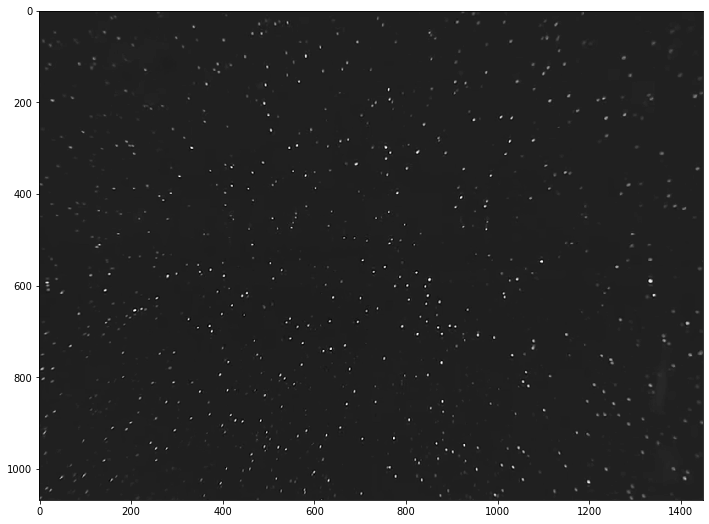

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(imgs[0])

def animate(ii):
  im.set_data(imgs[ii])

ani = animation.FuncAnimation(fig, animate, frames=len(imgs))

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

**Use thresholding and connected-component labeling to detect the tracer particles.  Create an animation of the detections in each frame.**

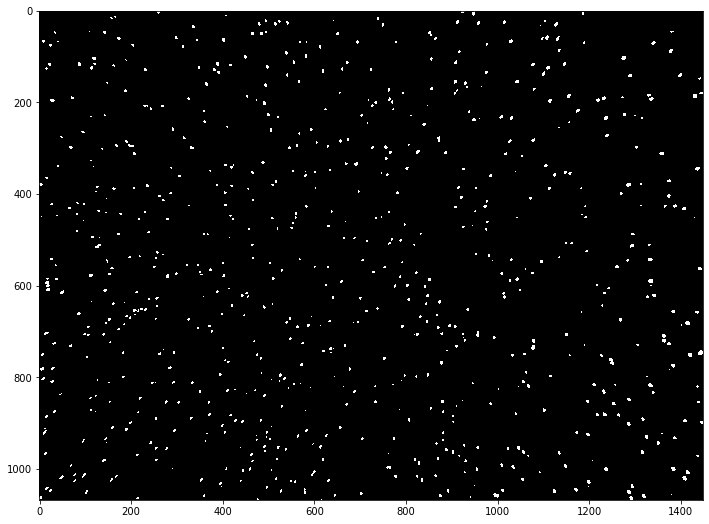

In [ ]:
thr = 0.2
plt.imshow(imgs[0]>thr)

In [ ]:
dets = []

for img in imgs:
  timg = img > thr
  labs, nlabs = snm.label(timg)
  com = np.array(snm.center_of_mass(timg, labs, range(1, nlabs+1)))
  dets.append(com)

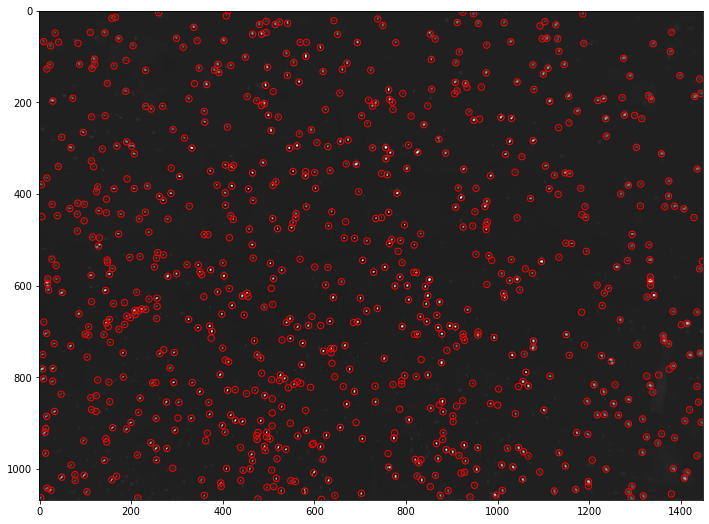

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(imgs[0])
pnts = ax.scatter(dets[0][:,1], dets[0][:, 0], facecolor = 'none', edgecolors='red', s=40)

def animate(ii):
  im.set_data(imgs[ii])
  pnts.set_offsets(dets[ii][:, :: -1])

ani = animation.FuncAnimation(fig, animate, frames=len(imgs))

In [ ]:
ani

Output hidden; open in https://colab.research.google.com to view.

**Use the version of `sort` [here](https://github.com/gdobler/sort) to track the particles in the fluid flow and make a plot of the trajectories, showing only those trajectories with lengths >10 frames.**

In [ ]:
mot = Sort()

In [ ]:
wid = 5
det_bb = []

for det in dets:
  oarr = np.ones((det.shape[0], 1))
  tbb = np.concatenate((det - wid, det + wid, oarr), axis=1)
  det_bb.append(tbb)

In [ ]:
tracks = [mot.update(i) for i in det_bb]

In [ ]:
all_ids = []

for track in tracks:
  for obj in track:
    all_ids.append(obj[4])

uids = np.unique(all_ids)

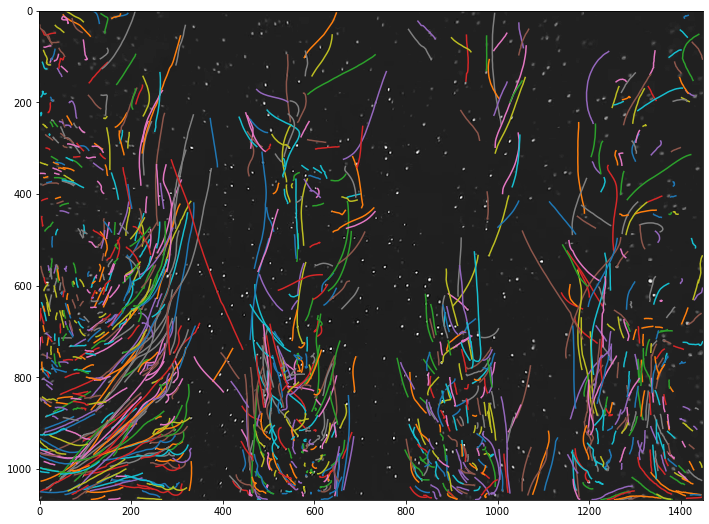

In [ ]:
trackd = {}
for uid in uids:
  trackd[uid] = []

for track in tracks:
  for obj in track:
    trackd[obj[4]].append([obj[0] + wid, obj[1] + wid])

fig, ax = plt.subplots()

for uid in uids:
  if len(trackd[uid]) > 10:
    pos = np.array(trackd[uid])
    ax.plot(pos[:, 1], pos[:, 0])

ax.imshow(imgs[0])
fig.show()

**Find the velocity (in pixels/frame) of the fastest moving particle in the flow and update the plot above to highlight the trajectory of this particle using a preattentive attribute.**

In [ ]:
#Function for calculating the length of a curve.

def CurveLength(a):

  if a.shape[0] == 1:
    return 0
  else:
    b = a[0:-1, :] - a[1:, :]
    dl = np.linalg.norm(b,axis=1)
    Length = sum(dl)
    return Length

In [ ]:
length = {}

for uid in uids:

  path = np.array(trackd[uid])
  length[uid] = CurveLength(path)


In [ ]:
#Find out the ID of the longest path

IdOfMax = max(length, key=length.get)

In [ ]:
#The spead of the fastest particle is 

v = length[IdOfMax]/(594)

print('The average speed of the fastest particle is {0} pixles/frame'.format(v))


The average speed of the fastest particle is 0.9018463442419558 pixles/frame


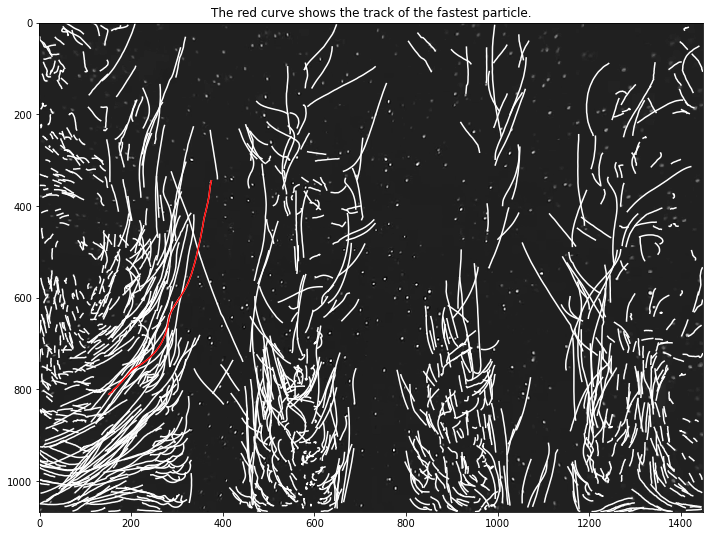

In [ ]:
fig, ax = plt.subplots()

for uid in uids:
  if len(trackd[uid]) > 10:
    pos = np.array(trackd[uid])
    ax.plot(pos[:, 1], pos[:, 0],'w')

ax.plot(np.array(trackd[IdOfMax])[:,1], np.array(trackd[IdOfMax])[:,0], 'r')

ax.imshow(imgs[0])
plt.title('The red curve shows the track of the fastest particle.')
fig.show()